# Introduction and problem statement

One of the major parts of the annotation process is assignment of classes to the objects in the image. Superannotate provides two quick methods to classify instances` 

1. Right-clicking the annotated object and assigning a class to it.

2. Defining a default class and annotated objects of that default class then going to the next and so on. 

It is worth mentioning that one can automate default class assignment (and much more) in the second option by the use of [Workflows](https://doc.superannotate.com/docs/workflow). 

Given that it is [possible](https://paperswithcode.com/sota/image-classification-on-imagenet) to reach top-1 accuracy of 81-86% on ImageNet dataset using models with less than 100M parameters such as [DeiT](https://paperswithcode.com/paper/training-data-efficient-image-transformers) and [EfficientNet](https://paperswithcode.com/paper/efficientnetv2-smaller-models-and-faster) we suggest to automate classification of already annotated instances using such models trained "under the hood". 

### The Method

1. Annotators manually finish annotating a certain number of instances. 
2. Once some threshhold is reached click to run training using these instances.
3. The platform will crop the instances using their inferred bounding boxes.
4. Create a dataset of these cropped instances.
5. Run the actual training on these images. 
6. Use the trained models to predict the class of the instances as well as next top 5 possibilities.

# Setting up the environment

To follow this notebook we need to install [CUDA](https://docs.nvidia.com/cuda/index.html) dependencies. As well as accombanying versions of [torch and torchvision](https://pytorch.org/get-started/locally/). 

You can follow through this notebook using your own [superannotate](https://app.devsuperannotate.com/) datasets. My own setup of Superannotate dataset is as follows:

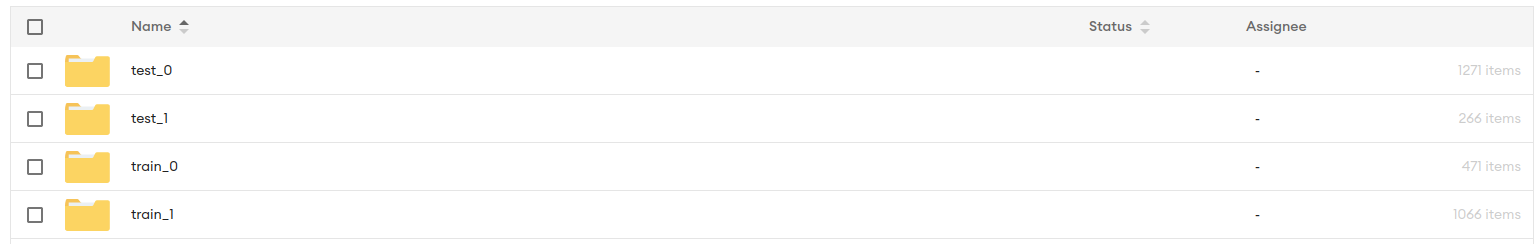

We will be using `train_0` and `test_0` folders as our datasets. As such our training set consists of 471 annotated images and our test set for 1066 annotated images. 

In [ ]:
!python3 -m pip install timm superannotate opencv-python tqdm

In [3]:
import superannotate as sa

SA-PYTHON-SDK - WARNING - There is a newer version of SuperAnnotate Python SDK available on PyPI. Run 'pip install --upgrade superannotate' to upgrade from your version 4.2.6 to 4.2.7


In order to inintialize the superannotate sdk you will need a config file. Which is simply a json file containing a single key called `token`. This token can be acquired from the [team settings](https://doc.superannotate.com/docs/settings) on the Superannotate.

In [4]:
sa.init('./config.json')

Once we have initialized the SDK, we need to download the dataset onto our local machine (server) on which we will run the training. To do that run the following commands on your machine, bu replacing the variables with appropriate folder structure.

In [ ]:
exp = sa.prepare_export(project = 'InstanceClassificationDemo', folders = ['test_0', 'train_0'], include_fuse = True)

In [ ]:
sa.download_export(project = 'InstanceClassificationDemo', export = exp, folder_path = './data')

This will download and extract your export into the directory `folder_path` after which you should have the following folder structure in the `data` folder.

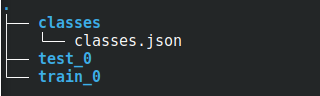

The `test_0` and `train_0` folders will contain the original images and their corresponding annotations in the 
Superannotate format. The `classes.json` will describe the available classes in the project.

Before we get further, a few more modifications to our folder structure. First let's add a `model` directory where we will store the ImageNet pretrained model that we will finetune. 

In [ ]:
!wget https://dl.fbaipublicfiles.com/deit/deit_small_patch16_224-cd65a155.pth ./data/model/deit_small.pth

And create an `output` folder where we will store our trained model. After running these commands the folder structure should be as follows:

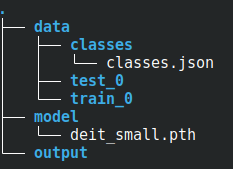


# Cropping out the instances, creating new dataset

In [ ]:
from pathlib import Path
from tqdm import tqdm
import json
import csv
import cv2

In [ ]:
# A class responsible for cropping the images into instances
# Generally speaking we will disallow instances smaller than 64 pixels
# as that could tamper with our training. Other models can be used to accomodate
# smaller instance sizes. 

class ImageCropper(object):
    min_max_fn = None
    cached_img = None
    cahced_img_name = None

    @classmethod
    def choose_min_max(cls, instance):
        if instance['type'] == 'bbox':
            return cls.min_max_bbox
        elif instance['type'] == 'polygon':
            return cls.min_max_polygon

    @classmethod
    def crop(cls, instance, fname, idx, output_dir):
        if instance['type'] == 'polygon':
            return None
        min_max_fn = cls.choose_min_max(instance)
    
        x, y, h, w = min_max_fn(instance)

        new_name = Path(output_dir) / (
            Path(fname).stem + '_' + str(idx)  + Path(fname).suffix
         )

        if fname != cls.cahced_img_name:
            cls.cached_img = cv2.imread(fname, cv2.IMREAD_UNCHANGED)
            cls.cached_img_name = fname

        cropped = cls.cached_img[y:y+h, x:x+w]
        try:
            cv2.imwrite(str(new_name), cropped)
        except Exception as e:
            print(x, y, h, w, fname, new_name)
            return None

        
        return new_name.name, instance['classId']
    
    @staticmethod
    def min_max_bbox(instance):
        min_coords = (
            min(instance['points']['x1'], instance['points']['x2']),
            min(instance['points']['y1'], instance['points']['y2'])
        )

        max_coords = (
            max(instance['points']['x1'], instance['points']['x2']),
            max(instance['points']['y1'], instance['points']['y2'])
        )

        h = int(max_coords[1] - min_coords[1])
        w = int(max_coords[0] - min_coords[0])
        min_coords = (int(min_coords[0]), int(min_coords[1]))

        return *min_coords, h, w

    @staticmethod
    def min_max_polygon(instance):
        min_coords = (
            min(instance['points'][0::2]), min(instance['points'][1::2])
        )
        max_coords = (
            max(instance['points'][0::2]), max(instance['points'][1::2])
        )

        h = int(max_coords[1] - min_coords[1])
        w = int(max_coords[0] - min_coords[0])

        min_coords = (int(min_coords[0]), int(min_coords[1]))
        return *min_coords, h, w

In [1]:
class DeiTConverter(object):
    
    def __init__(self, input_dir, output_dir, dataset_name, root):
        self.input_dir = Path(input_dir)
        self.output_dir = Path(output_dir)
        self.dataset_name = Path(dataset_name)
        self.root = Path(root)
        self.classes_mapper = self.create_classes_mapper()
        
        if not self.output_dir.is_dir():
            self.output_dir.mkdir()
            
    def annotation_generator(self):
        for file in self.input_dir.iterdir():
            if file.suffix != '.json' and 'fuse' not in str(file):
                continue
            data = None
            with file.open('r') as fp:
                data = json.load(fp)
                data['metadata']['image_path'] = str(file.parent / data['metadata']['name'])
                for instance in data['instances']:
                    instance['classId'] = self.classes_mapper[instance['className']]
            yield data
        
    def create_classes_mapper(self):
        # We will need to map our classNames to indices 0..n 
        # Where n is the number of classes in our dataset
        # Since this is the format needed for training
        classes_list = None
        with (self.root / 'classes/classes.json').open('r') as fp:
            classes_list = json.load(fp)
        
        classes_mapper = {x['name']: idx for idx, x in enumerate(classes_list)}
        with open('./model/classes_mapper.json', 'w') as fp:
            json.dump(classes_mapper, fp)
        return classes_mapper
    
    def convert_single_annotation(self, annotation):
        
        fpath = annotation['metadata']['image_path']
        per_image_annotations = [ImageCropper.crop(instance, fpath, idx, self.output_dir) 
                                 for idx, instance in enumerate(annotation['instances'])]
        
        per_image_annotations = [x for x in per_image_annotations if x]
        return per_image_annotations
    
    def write_to_file(self, results):
        with (self.root / self.dataset_name).open('w') as fp:
            writer = csv.writer(fp, delimiter=',')
            for item in results:
                writer.writerow(item)
                
    def convert_annotations(self):
        annotations = self.annotation_generator()
        result = []
        for annotation in annotations:
            result += self.convert_single_annotation(annotation)
        self.write_to_file(result)

In [ ]:
def run_conversion(input_dir, output_dir, dataset_name, root):
    converter = DeiTConverter(input_dir, output_dir, dataset_name, root)
    converter.convert_annotations()

In [ ]:
### Running conversion for a test/train pair
run_conversion('./data/train_0/', './data/cropped_train_0', 'cropped_train_0.csv', './data')
run_conversion('./data/test_0/', './data/cropped_test_0', 'cropped_test_0.csv', './data')


After running these cells, the final folder structure is the following.

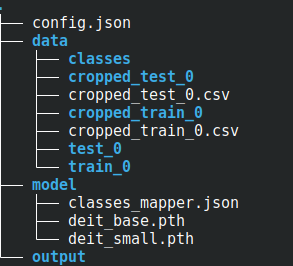

# Creating the training script

We are going to use the [DeiT](https://github.com/facebookresearch/deit) models. More specifically the DeiT-small model pretrained on ImageNet

In [ ]:
!git clone git@github.com:superannotateai/deit.git

Since this repository is geared towards using specific kind of dataset and has implemented their DataLoaders we will need to slightly modify the existing code to accomodate for our newly created dataset. 

Therefore we have forked he original repository and added a few of our modifications. Just as information here's what we've changed. No need to actually run these. 

There is no need to Run the following 2 cells inside this notebook. The changes are already implemented in our fork of the DeiT repository. Feel free to modify them as you like.

In [ ]:
# Copyright (c) 2015-present, Facebook, Inc.
# All rights reserved.
import os
import csv
import json

from torchvision import datasets, transforms
from torchvision.datasets.folder import ImageFolder, pil_loader, default_loader

from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from timm.data import create_transform


class SACustomDataset(ImageFolder):
    def __init__(
        self,
        root,
        train=True,
        year=2021,
        transform=None,
        target_transform=None,
        category='name',
        loader= pil_loader,
        extra_args = None
    ):
        self.root = root
        self.transform = transform
        self.loader = loader
        self.target_transform = target_transform
        self.year = year
        self.nb_classes = None
        self.train = train
        self.samples = []
        model_dir = extra_args.finetune
        if train:
            path_to_manifest  = extra_args.manifest_dirs['train_manifest']
            self.images_dir = extra_args.image_dirs['train_images_dir']
        else:
            path_to_manifest  = extra_args.manifest_dirs['test_manifest']
            self.images_dir = extra_args.image_dirs['test_images_dir']

        categories = {}
        path_to_classes = 'model/classes_mapper.json'
        with open(path_to_classes, 'r') as fp:
            classes = json.load(fp)
            self.nb_classes = len(classes)

        with open(path_to_manifest, 'r') as fp:
            reader = csv.reader(fp, delimiter=',')
            print(path_to_manifest)

            self.samples = [
                (self.make_img_path(row[0]), int(row[1])) for row in reader
            ]

    def make_img_path(self, img_name):
        return os.path.join(self.images_dir, img_name)


def build_dataset(is_train, args):
    transform = build_transform(is_train, args)

    if args.data_set == 'SACustomDataset':
        dataset = SACustomDataset(
            root = args.data_path,
            train=is_train,
            year=2021,
            category='name',
            transform=transform,
            extra_args = args
        )
        nb_classes = dataset.nb_classes
    print(dataset)

    return dataset, nb_classes


def build_transform(is_train, args):
    resize_im = args.input_size > 32
    if is_train:
        # this should always dispatch to transforms_imagenet_train
        transform = create_transform(
            input_size=args.input_size,
            is_training=True,
            color_jitter=args.color_jitter,
            auto_augment=args.aa,
            interpolation=args.train_interpolation,
            re_prob=args.reprob,
            re_mode=args.remode,
            re_count=args.recount,
        )
        if not resize_im:
            # replace RandomResizedCropAndInterpolation with
            # RandomCrop
            transform.transforms[0] = transforms.RandomCrop(
                args.input_size, padding=4
            )
        return transform

    t = []
    if resize_im:
        size = int((256 / 224) * args.input_size)
        t.append(
            transforms.Resize(size, interpolation=3
                             ),  # to maintain same ratio w.r.t. 224 images
        )
        t.append(transforms.CenterCrop(args.input_size))

    t.append(transforms.ToTensor())
    t.append(transforms.Normalize(IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD))
    return transforms.Compose(t)

In [ ]:
### Replace with main.py

# Copyright (c) 2015-present, Facebook, Inc.
# All rights reserved.
import datetime
import numpy as np
import time
import torch
import shutil
import torch.backends.cudnn as cudnn
import json
import sys
import os

from pathlib import Path

from timm.data import Mixup
from timm.models import create_model
from timm.loss import LabelSmoothingCrossEntropy, SoftTargetCrossEntropy
from timm.scheduler import create_scheduler
from timm.optim import create_optimizer
from timm.utils import NativeScaler, get_state_dict, ModelEma

from deit.datasets import build_dataset
from deit.engine import train_one_epoch, evaluate
from deit.losses import DistillationLoss
from deit.samplers import RASampler
import deit.models as models
import deit.utils as utils

def train(args):
    utils.init_distributed_mode(args)

    print(args)


    if args.distillation_type != 'none' and args.finetune and not args.eval:
        raise NotImplementedError("Finetuning with distillation not yet supported")

    device = torch.device('cpu')  # torch.device(args.device)
    device = torch.device(args.device)

    # fix the seed for reproducibility
    seed = args.seed + utils.get_rank()
    torch.manual_seed(seed)
    np.random.seed(seed)
    # random.seed(seed)

    cudnn.benchmark = True

    dataset_train, args.nb_classes = build_dataset(is_train=True, args=args)

    dataset_val, _ = build_dataset(is_train=False, args=args)

    if True:  # args.distributed:
        num_tasks = utils.get_world_size()
        global_rank = utils.get_rank()
        if args.repeated_aug:
            sampler_train = RASampler(
                dataset_train, num_replicas=num_tasks, rank=global_rank, shuffle=True
            )
        else:
            sampler_train = torch.utils.data.DistributedSampler(
                dataset_train, num_replicas=num_tasks, rank=global_rank, shuffle=True
            )
        if args.dist_eval:
            if len(dataset_val) % num_tasks != 0:
                print('Warning: Enabling distributed evaluation with an eval dataset not divisible by process number. '
                      'This will slightly alter validation results as extra duplicate entries are added to achieve '
                      'equal num of samples per-process.')
            sampler_val = torch.utils.data.DistributedSampler(
                dataset_val, num_replicas=num_tasks, rank=global_rank, shuffle=False)
        else:
            sampler_val = torch.utils.data.SequentialSampler(dataset_val)
    else:
        sampler_train = torch.utils.data.RandomSampler(dataset_train)
        sampler_val = torch.utils.data.SequentialSampler(dataset_val)

    data_loader_train = torch.utils.data.DataLoader(
        dataset_train, sampler=sampler_train,
        batch_size=args.batch_size,
        num_workers= 0,# args.num_workers,
        pin_memory=args.pin_mem,
        drop_last=True,
    )
    data_loader_val = torch.utils.data.DataLoader(
        dataset_val, sampler=sampler_val,
        batch_size=int(1.5 * args.batch_size),
        num_workers=0, #args.num_workers,
        pin_memory=args.pin_mem,
        drop_last=False
    )

    mixup_fn = None
    mixup_active = args.mixup > 0 or args.cutmix > 0. or args.cutmix_minmax is not None
    if mixup_active:
        mixup_fn = Mixup(
            mixup_alpha=args.mixup, cutmix_alpha=args.cutmix, cutmix_minmax=args.cutmix_minmax,
            prob=args.mixup_prob, switch_prob=args.mixup_switch_prob, mode=args.mixup_mode,
            label_smoothing=args.smoothing, num_classes=args.nb_classes)

    print(f"Creating model: {args.model}")
    print(args.nb_classes)
    model = create_model(
        args.model,
        pretrained=False,
        num_classes=args.nb_classes,
        drop_rate=args.drop,
        drop_path_rate=args.drop_path,
        drop_block_rate=None,
    )

    if args.finetune:
        checkpoint = torch.load(args.finetune, map_location='cpu')

        checkpoint_model = checkpoint['model']
        state_dict = model.state_dict()
        for k in ['head.weight', 'head.bias', 'head_dist.weight', 'head_dist.bias']:
            if k in checkpoint_model and checkpoint_model[k].shape != state_dict[k].shape:
                print(f"Removing key {k} from pretrained checkpoint")
                del checkpoint_model[k]

        # interpolate position embedding
        pos_embed_checkpoint = checkpoint_model['pos_embed']
        embedding_size = pos_embed_checkpoint.shape[-1]
        num_patches = model.patch_embed.num_patches
        num_extra_tokens = model.pos_embed.shape[-2] - num_patches
        # height (== width) for the checkpoint position embedding
        orig_size = int((pos_embed_checkpoint.shape[-2] - num_extra_tokens) ** 0.5)
        # height (== width) for the new position embedding
        new_size = int(num_patches ** 0.5)
        # class_token and dist_token are kept unchanged
        extra_tokens = pos_embed_checkpoint[:, :num_extra_tokens]
        # only the position tokens are interpolated
        pos_tokens = pos_embed_checkpoint[:, num_extra_tokens:]
        pos_tokens = pos_tokens.reshape(-1, orig_size, orig_size, embedding_size).permute(0, 3, 1, 2)
        pos_tokens = torch.nn.functional.interpolate(
            pos_tokens, size=(new_size, new_size), mode='bicubic', align_corners=False)
        pos_tokens = pos_tokens.permute(0, 2, 3, 1).flatten(1, 2)
        new_pos_embed = torch.cat((extra_tokens, pos_tokens), dim=1)
        checkpoint_model['pos_embed'] = new_pos_embed

        model.load_state_dict(checkpoint_model, strict=False)

    model.to(device)

    model_ema = None
    if args.model_ema:
        # Important to create EMA model after cuda(), DP wrapper, and AMP but before SyncBN and DDP wrapper
        model_ema = ModelEma(
            model,
            decay=args.model_ema_decay,
            device='cpu', #if args.model_ema_force_cpu else '',
            resume='')

    model_without_ddp = model
    if args.distributed:
        model = torch.nn.parallel.DistributedDataParallel(model, device_ids=[args.xgpu])
        model_without_ddp = model.module
    n_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print('number of params:', n_parameters)

    linear_scaled_lr = args.lr * args.batch_size * utils.get_world_size() / 512.0
    args.lr = linear_scaled_lr
    optimizer = create_optimizer(args, model_without_ddp)
    loss_scaler = NativeScaler()

    lr_scheduler, _ = create_scheduler(args, optimizer)

    criterion = LabelSmoothingCrossEntropy()

    if args.mixup > 0.:
        # smoothing is handled with mixup label transform
        criterion = SoftTargetCrossEntropy()
    elif args.smoothing:
        criterion = LabelSmoothingCrossEntropy(smoothing=args.smoothing)
    else:
        criterion = torch.nn.CrossEntropyLoss()

    teacher_model = None
    if args.distillation_type != 'none':
        assert args.teacher_path, 'need to specify teacher-path when using distillation'
        print(f"Creating teacher model: {args.teacher_model}")
        teacher_model = create_model(
            args.teacher_model,
            pretrained=False,
            num_classes=args.nb_classes,
            global_pool='avg',
        )
        checkpoint = torch.load(args.teacher_path, map_location='cpu')
        teacher_model.load_state_dict(checkpoint['model'])
        teacher_model.to(device)
        teacher_model.eval()

    # wrap the criterion in our custom DistillationLoss, which
    # just dispatches to the original criterion if args.distillation_type is 'none'
    criterion = DistillationLoss(
        criterion, teacher_model, args.distillation_type, args.distillation_alpha, args.distillation_tau
    )

    output_dir = Path(args.output_dir)
    if args.resume:
        if args.resume.startswith('https'):
            checkpoint = torch.hub.load_state_dict_from_url(
                args.resume, map_location='cpu', check_hash=True)
        else:
            checkpoint = torch.load(args.resume, map_location='cpu')
        model_without_ddp.load_state_dict(checkpoint['model'])
        if not args.eval and 'optimizer' in checkpoint and 'lr_scheduler' in checkpoint and 'epoch' in checkpoint:
            optimizer.load_state_dict(checkpoint['optimizer'])
            lr_scheduler.load_state_dict(checkpoint['lr_scheduler'])
            args.start_epoch = checkpoint['epoch'] + 1
            if args.model_ema:
                utils._load_checkpoint_for_ema(model_ema, checkpoint['model_ema'])
            if 'scaler' in checkpoint:
                loss_scaler.load_state_dict(checkpoint['scaler'])

    if args.eval:
        test_stats = evaluate(data_loader_val, model, device)
        print(f"Accuracy of the network on the {len(dataset_val)} test images: {test_stats['acc1']:.1f}%")
        return

    print(f"Start training for {args.epochs} epochs")
    start_time = time.time()
    max_accuracy = 0.0
    for epoch in range(args.start_epoch, args.epochs):
        if args.distributed:
            data_loader_train.sampler.set_epoch(epoch)
        train_stats = train_one_epoch(
            model, criterion, data_loader_train,
            optimizer, device, epoch, loss_scaler,
            args.clip_grad, model_ema, mixup_fn,
            set_training_mode=args.finetune == ''  # keep in eval mode during finetuning
        )

        lr_scheduler.step(epoch)
        if args.output_dir:
            checkpoint_paths = [output_dir / 'checkpoint.pth']
            for checkpoint_path in checkpoint_paths:
                utils.save_on_master({
                    'model': model_without_ddp.state_dict(),
                    'optimizer': optimizer.state_dict(),
                    'lr_scheduler': lr_scheduler.state_dict(),
                    'epoch': epoch,
                    'model_ema': get_state_dict(model_ema),
                    'scaler': loss_scaler.state_dict(),
                    'args': args,
                }, checkpoint_path)

        if (epoch + 1) % args.eval_period:
            test_stats = evaluate(data_loader_val, model, device)
            print(test_stats)
            print(f"Accuracy of the network on the {len(dataset_val)} test images: {test_stats['acc1']:.1f}%")
            max_accuracy = max(max_accuracy, test_stats["acc1"])
            print(f'Max accuracy: {max_accuracy:.2f}%')

            log_stats = {**{f'train_{k}': v for k, v in train_stats.items()},
                         **{f'test_{k}': v for k, v in test_stats.items()},
                         'epoch': epoch,
                         'n_parameters': n_parameters}

        if args.output_dir and utils.is_main_process():
            with (output_dir / "log.txt").open("a") as f:
                f.write(json.dumps(log_stats) + "\n")

        final_path = output_dir / 'final.pth'
        utils.save_on_master({
            'model': model_without_ddp.state_dict(),
            'optimizer': optimizer.state_dict(),
            'lr_scheduler': lr_scheduler.state_dict(),
            'epoch': epoch,
            'model_ema': get_state_dict(model_ema),
            'scaler': loss_scaler.state_dict(),
            'args': args,
        }, final_path)

    total_time = time.time() - start_time
    total_time_str = str(datetime.timedelta(seconds=int(total_time)))
    print('Training time {}'.format(total_time_str))


if __name__ == '__main__':
    args = parse_arguments()

    if args.output_dir:
        Path(args.output_dir).mkdir(parents=True, exist_ok=True)
    try:
        main(args)
    except Exception as e:
        print("ERROR", e)



# Running the training job

In [ ]:
from deit.train import train

In [ ]:
def setup_args(
    lr, batch_size, num_epochs, eval_period, model_dir, root, manifest_dirs,
    image_dirs
):
    
    """
    Setting up training arguments, return a Namespace
    
    param lr: learning rate
    param batch_size: Number of images per batch
    param num_epochs: Number of training epochs
    param eval_period: Number of epochs after which an evaluation script is run
    param model_dir: The directory of the pretrained model
    param root: The root directory where data, model and output are located
    param manifest_dirs: paths to manifest.csv files - where image_names and their classes are specified
                         relative to the root parameter.
    param image_dirs: path to folders with training images, relative to the root parameter
    """

    args = None
    with Path('./deit/default_params.json').open('r') as fp:
        args = json.load(fp)

    args['batch_size'] = batch_size
    args['epochs'] = num_epochs
    args['eval_period'] = eval_period
    args['lr'] = lr
    args['finetune'] = model_dir
    args['data_path'] = root
    args['manifest_dirs'] = manifest_dirs
    args['image_dirs'] = images_dirs

    args = Namespace(**args)

    return args

In [ ]:
manifest_dirs = {
    'train_manifest':'./data/cropped_train_0.csv',
    'test_manifest': './data/cropped_test_0.csv'
}

image_dirs = {
    'train_images_dir':'./data/cropped_train_0',
    'test_images_dir': './data/cropped_test_0'
}

args = setup_args(
    lr=0.002,
    batch_size=2,
    num_epochs=20,
    eval_period=4,
    model_dir='./model/deit_small.pth',
    root='./data',
    manifest_dirs = manifest_dirs,
    images_dirs = image_dirs)

train(args)

So we've got 76% top1 and 95% top5 accuracy using a very small model.

# Automating prediction to work with the platform

Now that we have a working model we need to be able to use it to classify our instances, to do that we need:
    1. Create an image with annotated - but not necessarily classified - instances.
    2. Download the image and its annotations using SuperAnnotate SDK 
    3. Load our trained model into working memory.
    4. Iterate over all instances in the annotation.
    5. Crop out those instances.
    6. Run prediction in on each of the crops.
    7. Replace the className fields in the annotation json
    8. Reupload the annotation.